In [7]:
%pip install -q \
  antropy \
  heartpy \
  openpyxl \
  pandas \
  scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# set up the environment for the notebook
import os
os.environ['PYCARET_CUSTOM_LOGGING_LEVEL'] = 'CRITICAL'

import pandas as pd
pd.set_option('display.max_columns', 128)

In [3]:
# prepare the raw data
from pathlib import Path
import pandas as pd
from zipfile import ZipFile

# extract the compressed raw data files
raw_data_dir = '../datasets/swell/data/raw'
if Path(raw_data_dir).exists():
  print(f'Raw data files were already extracted')
else:
  ZipFile(f'{raw_data_dir}.zip', 'r').extractall('..')
  print(f'Raw data files have been extracted')
# load the data
print(f'Loading data files')

# combine the label data
LABEL_DATA = (pd.concat(
    ignore_index=True,
    objs=pd.read_excel(
      io=f'{raw_data_dir}/labels/hrv stress labels.xlsx',
      index_col=0,
      sheet_name=None,
    ),
  )[['subject', 'ElapsedTime', 'label']])
display(LABEL_DATA)

# combine the RRI data
RRI_DATA = []
for rri_data_path in Path(raw_data_dir).glob('rri/*.csv'):
  data = pd.read_csv(rri_data_path)
  data['subject'] = rri_data_path.stem
  data.rename(columns={'Time': 'ElapsedTime (sec)'}, inplace=True)
  RRI_DATA.append(data)

RRI_DATA = pd.concat(objs=RRI_DATA, ignore_index=True)
display(RRI_DATA)

Raw data files were already extracted
Loading data files


,subject,ElapsedTime,label
0,p1,0,rest
1,p1,1,rest
2,p1,2,rest
3,p1,3,rest
4,p1,4,rest
...,...,...,...
3135,p25,170,time pressure
3136,p25,171,time pressure
3137,p25,172,time pressure
3138,p25,173,time pressure


,ElapsedTime (sec),rri,subject
0,1.052246,607.42188,p19
1,1.302246,907.99370,p19
2,1.552246,1066.60650,p19
3,1.802246,1121.94730,p19
4,2.052246,1112.70300,p19
...,...,...,...
704449,8643.416500,645.27258,p14
704450,8643.666500,640.88917,p14
704451,8643.916500,639.66372,p14
704452,8644.166500,642.82421,p14


In [4]:
# prepare the data for inserting labels
RRI_DATA['ElapsedTime'] = RRI_DATA['ElapsedTime (sec)'].astype(int) // 60
RRI_DATA['label'] = pd.NA
RRI_DATA = RRI_DATA.set_index(['subject', 'ElapsedTime']).sort_index()
RRI_DATA

ElapsedTime (sec)        rri label
subject ElapsedTime                                    
p1      0                     1.265625  870.11719   NaN
        0                     1.515625  885.36996   NaN
        0                     1.765625  890.18974   NaN
        0                     2.015625  886.73851   NaN
        0                     2.265625  877.17820   NaN
...                                ...        ...   ...
p9      127                7644.475100  884.87308   NaN
        127                7644.725100  903.45423   NaN
        127                7644.975100  920.95615   NaN
        127                7645.225100  936.70456   NaN
        127                7645.475100  950.02517   NaN

[704454 rows x 3 columns]

In [10]:
# mapping the labels to the RRI data
for entry in LABEL_DATA.itertuples():
  index = (entry.subject, entry.ElapsedTime)
  try:
    RRI_DATA.loc[index] = RRI_DATA.loc[index].assign(label=entry.label)
  except:
    continue
RRI_DATA.reset_index(inplace=True)
RRI_DATA

,subject,ElapsedTime,ElapsedTime (sec),rri,label
0,p1,0,1.265625,870.11719,rest
1,p1,0,1.515625,885.36996,rest
2,p1,0,1.765625,890.18974,rest
3,p1,0,2.015625,886.73851,rest
4,p1,0,2.265625,877.17820,rest
...,...,...,...,...,...
704449,p9,127,7644.475100,884.87308,interruption
704450,p9,127,7644.725100,903.45423,interruption
704451,p9,127,7644.975100,920.95615,interruption
704452,p9,127,7645.225100,936.70456,interruption


In [18]:
from typing import Iterable

def extract_features_from_rri(rr: Iterable[float], w = 300) -> dict[str, float]:
  '''
  Extracts features from a series of RR intervals.
  RR intervals are in milliseconds.
  '''

  import numpy as np
  from scipy.interpolate import interp1d
  from scipy.stats import skew, kurtosis, differential_entropy, entropy
  from scipy.signal import welch
  from antropy import sample_entropy, higuchi_fd

  rr = np.array(rr)
  mrr = np.mean(rr)
  sdrr = np.std(rr)
  sd = np.diff(rr)
  sdsd = np.std(sd)
  rmssd = np.mean(sd ** 2) ** 0.5
  asd = abs(sd)
  rel_rr = sd / (rr[1:] + rr[:-1]) * 2
  rel_mrr = np.mean(rel_rr)
  rel_sd = np.diff(rel_rr)
  rel_sdrr = np.std(rel_rr)
  rel_rmssd = np.mean(rel_sd ** 2) ** 0.5
  rr_x = np.cumsum(rr) / 1000
  rr_x_new = np.arange(1, max(rr_x), 0.25)
  int_rr = interp1d(x=rr_x, y=rr, kind='cubic')(rr_x_new)
  fr, ps = welch(x=int_rr, fs=4, nperseg=min(w * 4, len(rr_x_new)))
  df = fr[1] - fr[0]
  vlf = np.trapz(y=abs(ps[(fr >= 0.003) & (fr < 0.04)]), dx=df)
  lf = np.trapz(y=abs(ps[(fr >= 0.04) & (fr < 0.15)]), dx=df)
  hf = np.trapz(y=abs(ps[(fr >= 0.15) & (fr < 0.4)]), dx=df)
  nu = lf + hf
  tp = vlf + nu
  return {
    'MEAN_RR': mrr,
    'MEDIAN_RR': np.median(rr),
    'SDRR': sdrr,
    'RMSSD': rmssd,
    'SDSD': sdsd,
    'SDRR_RMSSD': sdrr / rmssd,
    'HR': 60000 / mrr,
    'pNN25': np.mean(asd > 25) * 100,
    'pNN50': np.mean(asd > 50) * 100,
    'KURT': kurtosis(rr),
    'SKEW': skew(rr),
    'SD1': (2 ** -0.5) * sdsd,
    'SD2': (2 * (sdrr ** 2) - 0.5 * (sdsd ** 2)) ** 0.5,
    'MEAN_REL_RR': rel_mrr,
    'MEDIAN_REL_RR': np.median(rel_rr),
    'SDRR_REL_RR': rel_sdrr,
    'RMSSD_REL_RR': rel_rmssd,
    'SDSD_REL_RR': np.std(rel_sd),
    'SDRR_RMSSD_REL_RR': rel_sdrr / rel_rmssd,
    'KURT_REL_RR': kurtosis(rel_rr),
    'SKEW_REL_RR': skew(rel_rr),
    'VLF': vlf,
    'VLF_PCT': vlf / tp * 100,
    'LF': lf,
    'LF_PCT': lf / tp * 100,
    'LF_NU': lf / nu * 100,
    'HF': hf,
    'HF_PCT': hf / tp * 100,
    'HF_NU': hf / nu * 100,
    'TP': tp,
    'LF_HF': lf / hf,
    'HF_LF': hf / lf,
    'sampen': sample_entropy(rr),
    'higuci': higuchi_fd(rr),
  }

extract_features_from_rri(DATA[22:100])

{'MEAN_RR': 772.2291565384617,
 'MEDIAN_RR': 801.319035,
 'SDRR': 62.694172798529664,
 'RMSSD': 6.4690749060156625,
 'SDSD': 5.9557587220566734,
 'SDRR_RMSSD': 9.691366031367124,
 'HR': 77.6971440303441,
 'pNN25': 0.0,
 'pNN50': 0.0,
 'KURT': -0.2433462083682425,
 'SKEW': -1.0305606817190058,
 'SD1': 4.2113573794772,
 'SD2': 88.56287639189524,
 'MEAN_REL_RR': -0.0035134677080664563,
 'MEDIAN_REL_RR': -0.003033698281146674,
 'SDRR_REL_RR': 0.007897783669678951,
 'RMSSD_REL_RR': 0.0032848015837496866,
 'SDSD_REL_RR': 0.0032841273888213193,
 'SDRR_RMSSD_REL_RR': 2.4043411659170677,
 'KURT_REL_RR': 0.21950273913638751,
 'SKEW_REL_RR': 0.27425987980183586,
 'VLF': 280.6832915291116,
 'VLF_PCT': 44.53858540291637,
 'LF': 346.95391975141996,
 'LF_PCT': 55.054352190117775,
 'LF_NU': 99.26604395159572,
 'HF': 2.565317582750673,
 'HF_PCT': 0.4070624069658723,
 'HF_NU': 0.733956048404285,
 'TP': 630.2025288632822,
 'LF_HF': 135.24794048282985,
 'HF_LF': 0.007393827931353625,
 'sampen': 0.23818872

In [30]:
from heartpy.analysis import calc_fd_measures

fdms = calc_fd_measures(working_data={'RR_list_cor': DATA}, welch_wsize=300)[1]
{  
 'VLF': fdms['vlf'],
 'VLF_PCT': fdms['vlf_perc'],
 'LF': fdms['lf'],
 'LF_PCT': fdms['lf_perc'],
 'LF_NU': fdms['lf_nu'],
 'HF': fdms['hf'],
 'HF_PCT': fdms['hf_perc'],
 'HF_NU': fdms['hf_nu'],
 'TP': fdms['p_total'],
 'LF_HF': fdms['lf/hf'],
 'HF_LF': 1 / fdms['lf/hf'],
}

{'VLF': 4182.387658490269,
 'VLF_PCT': 85.71381804356676,
 'LF': 693.7839983641472,
 'LF_PCT': 14.218403518048994,
 'LF_NU': 99.5255664628174,
 'HF': 3.3072345939126016,
 'HF_PCT': 0.06777843838424613,
 'HF_NU': 0.4744335371825827,
 'TP': 4879.478891448329,
 'LF_HF': 209.7776794065796,
 'HF_LF': 0.004766951387911269}

In [1]:
import heartpy as hap

DATA = hap.get_data(
  filename='../datasets/swell/data/raw/rri/p1.csv',
  column_name='rri',
)
print(('type: ', type(DATA), 'shape: ', DATA.shape))

# hap.process_rr(
#   rr_list=DATA,
#   calc_freq=True,
#   square_spectrum=False,
# )

('type: ', <class 'numpy.ndarray'>, 'shape: ', (35974,))


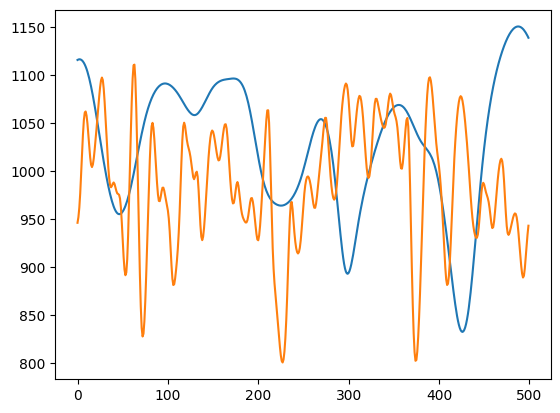

In [39]:
from matplotlib import pyplot as plt

plt.plot(rr_interpolated[1000:1500])
plt.plot(DATA[1000:1500])